In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from astropy.coordinates import SkyCoord
import astropy.units as u
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from time import time
from copy import deepcopy
# from Equi2GalMLP import EquatorialToGalacticMLP
from LossFunc import GreatCircleLoss, GreatCircleLoss_no_average
from tqdm import tqdm
import time
from torch.utils.data import Dataset
import torch.nn.functional as F
import random
from dataloader import get_dataloaders
import numpy as np
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from pathlib import Path
from sklearn.metrics import auc as sklearn_auc
from plotter import plot_combined_results
from datetime import datetime as t
from train_utils import select_gpu, calculate_pr_auc, get_class_counts, calculate_val_loss



# torch.manual_seed(42)          # CPU
# torch.cuda.manual_seed(42)     # Current GPU
# torch.cuda.manual_seed_all(42) # All GPUs (if multi-GPU)

# # Set NumPy seed
# np.random.seed(42)

# # Set Python's built-in random seed
# random.seed(42)

# # Additional PyTorch settings for determinism
# torch.backends.cudnn.deterministic = True  # Uses deterministic algorithms
# torch.backends.cudnn.benchmark = False     # Disables benchmarking (for reproducibility)

c:\Users\hyngv\miniforge3\envs\ztf_2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def generate_data(num_samples=10000):
        """Generate training data with RA in degrees (0-360) and Dec in degrees (-90 to 90)"""
        ra = np.random.uniform(0, 360, num_samples)
        dec = np.random.uniform(-90, 90, num_samples)
        
        # Convert to galactic coordinates using astropy
        equatorial = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
        galactic = equatorial.galactic
        
        # Extract l (0-360) and b (-90 to 90) in degrees
        l = galactic.l.deg
        b = galactic.b.deg
        
        # Normalize all values to [-1, 1] range
        inputs = np.column_stack((ra / 180 - 1, dec / 90))  # RA: [0,360] -> [-1,1], Dec: [-90,90] -> [-1,1]
        answers = np.column_stack((l / 180 - 1, b / 90))     # l: [0,360] -> [-1,1], b: [-90,90] -> [-1,1]
        
        
        return inputs, answers 

In [4]:
import numpy as np
import torch

def get_cutoff_acc(model, X, y, cutoff_deg=1):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        loss = GreatCircleLoss(outputs, y).item()
        
        # Convert predictions and true values to degrees
        true_l, true_b = y[:, 0].cpu().numpy(), y[:, 1].cpu().numpy()
        pred_l, pred_b = outputs[:, 0].cpu().numpy(), outputs[:, 1].cpu().numpy()
        
        true_l = (true_l + 1) * 180  # [-1,1] -> [0,360]
        true_b = true_b * 90         # [-1,1] -> [-90,90]
        pred_l = (pred_l + 1) * 180
        pred_b = pred_b * 90
        
        # Convert degrees to radians for great circle distance calculation
        true_l_rad = np.radians(true_l)
        true_b_rad = np.radians(true_b)
        pred_l_rad = np.radians(pred_l)
        pred_b_rad = np.radians(pred_b)
        
        # Calculate great circle distance for each point
        # Haversine formula
        dlon = pred_l_rad - true_l_rad
        dlat = pred_b_rad - true_b_rad
        a = np.sin(dlat/2)**2 + np.cos(true_b_rad) * np.cos(pred_b_rad) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        great_circle_dist_deg = np.degrees(c)
        
        # Calculate accuracy based on great circle distance
        correct = np.sum(great_circle_dist_deg < cutoff_deg)
        total = len(true_l)
        acc = correct / total
        
        # Also compute individual accuracies for l and b (optional)
        l_diff = np.abs(true_l - pred_l)
        l_diff = np.minimum(l_diff, 360 - l_diff)
        b_diff = np.abs(true_b - pred_b)
        
        correct_l = np.sum(l_diff < cutoff_deg)
        correct_b = np.sum(b_diff < cutoff_deg)
        
        acc_l = correct_l / total
        acc_b = correct_b / total
        
    return loss, acc_l, acc_b, acc




## And lets also make a plotting function real quick

def plot_training_history(training_history, cutoff_deg):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Loss plot
        ax1.plot(training_history['train_loss'], label='Train Loss')
        ax1.plot(training_history['val_loss'], label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        
        # Accuracy plot
        ax2.plot(training_history['train_acc'], label='Train Accuracy')
        ax2.plot(training_history['val_acc'], label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title(f'Accuracy (Cutoff = {cutoff_deg}°)')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

In [5]:
'''
There are tons of different options for how to structure these, but we'll do a simple one for this example:
'''

class EquatorialToGalacticMLP(nn.Module):
    """An MLP for converting equatorial to galactic coordinates.
    
    Takes equatorial coordinates (right ascension and declination) as input
    and outputs the corresponding galactic coordinates (l, b) in normalized form.
    
    The Tanh output activation assumes coordinates are normalized to [-1, 1].
    
    Args:
        input_size (int, optional): Number of input features. Defaults to 2 for (ra, dec).
        hidden_size (int, optional): Number of neurons in hidden layers. Defaults to 128.


    Example:
        >>> model = EquatorialToGalacticMLP()
        >>> equatorial_coords = torch.tensor([[0.5, -0.2]])  # normalized (ra, dec)
        >>> galactic_coords = model(equatorial_coords)  # predicted (l, b)
    """
    def __init__(self, input_size=2, output_size=2, hidden_size=64):
        super(EquatorialToGalacticMLP, self).__init__()
        
        # main body blocks
        self.block1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )

        self.block2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )



        
        # output block 
        self.end = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Tanh()
        )

    
    def forward(self, x):
        block1_feats = self.block1(x)
        
        block2_feats = self.block2(block1_feats)



        out = self.end(block2_feats)
    
        return out



Using device:cpu


Epoch 1/200: Train Loss: 14.8211, Val Loss: 7.0077 | Train Acc: 9.38%, Val Acc: 7.38% | l Acc: 29.73%, b Acc: 19.39%


Epoch 2/200: Train Loss: 5.9221, Val Loss: 4.6775 | Train Acc: 22.40%, Val Acc: 24.25% | l Acc: 40.58%, b Acc: 47.14%


Epoch 3/200: Train Loss: 4.6865, Val Loss: 3.6018 | Train Acc: 24.76%, Val Acc: 36.18% | l Acc: 44.50%, b Acc: 70.54%


Epoch 4/200: Train Loss: 3.9665, Val Loss: 3.3979 | Train Acc: 29.80%, Val Acc: 23.28% | l Acc: 46.48%, b Acc: 53.44%


Epoch 5/200: Train Loss: 3.3298, Val Loss: 2.8127 | Train Acc: 36.41%, Val Acc: 40.27% | l Acc: 46.00%, b Acc: 72.28%


Epoch 6/200: Train Loss: 3.1618, Val Loss: 2.9894 | Train Acc: 35.38%, Val Acc: 38.55% | l Acc: 61.20%, b Acc: 53.44%


Epoch 7/200: Train Loss: 2.8713, Val Loss: 2.9615 | Train Acc: 36.08%, Val Acc: 12.83% | l Acc: 16.18%, b Acc: 67.06%


Epoch 8/200: Train Loss: 2.8389, Val Loss: 2.5614 | Train Acc: 34.08%, Val Acc: 30.57% | l Acc: 30.91%, b Acc: 83.41%


Epoch 9/200: Train Loss: 2.4457, Val Loss: 2.1792 | Train Acc: 43.36%, Val Acc: 41.62% | l Acc: 59.52%, b Acc: 63.37%


Epoch 10/200: Train Loss: 2.2096, Val Loss: 2.5328 | Train Acc: 48.06%, Val Acc: 29.50% | l Acc: 40.97%, b Acc: 74.03%


Epoch 11/200: Train Loss: 2.1807, Val Loss: 2.2355 | Train Acc: 46.49%, Val Acc: 25.14% | l Acc: 49.58%, b Acc: 61.17%


Epoch 12/200: Train Loss: 2.1363, Val Loss: 1.5445 | Train Acc: 44.32%, Val Acc: 66.12% | l Acc: 74.48%, b Acc: 85.39%


Epoch 13/200: Train Loss: 2.0401, Val Loss: 1.9265 | Train Acc: 48.51%, Val Acc: 35.21% | l Acc: 51.02%, b Acc: 73.98%


Epoch 14/200: Train Loss: 2.0336, Val Loss: 1.7143 | Train Acc: 45.94%, Val Acc: 45.99% | l Acc: 44.94%, b Acc: 89.80%


Epoch 15/200: Train Loss: 1.8477, Val Loss: 2.0124 | Train Acc: 50.83%, Val Acc: 33.53% | l Acc: 56.81%, b Acc: 65.70%


Epoch 16/200: Train Loss: 1.8437, Val Loss: 2.3275 | Train Acc: 51.83%, Val Acc: 23.23% | l Acc: 40.63%, b Acc: 54.41%


Epoch 17/200: Train Loss: 1.2238, Val Loss: 1.3708 | Train Acc: 79.64%, Val Acc: 67.69% | l Acc: 78.84%, b Acc: 78.64%


Epoch 18/200: Train Loss: 1.2220, Val Loss: 1.0507 | Train Acc: 79.72%, Val Acc: 84.22% | l Acc: 80.42%, b Acc: 95.16%


Epoch 19/200: Train Loss: 1.2663, Val Loss: 1.0431 | Train Acc: 75.98%, Val Acc: 85.66% | l Acc: 82.69%, b Acc: 95.50%


Epoch 20/200: Train Loss: 1.1500, Val Loss: 1.1270 | Train Acc: 79.48%, Val Acc: 79.55% | l Acc: 80.71%, b Acc: 91.41%


Epoch 21/200: Train Loss: 1.1521, Val Loss: 1.2091 | Train Acc: 78.55%, Val Acc: 81.86% | l Acc: 84.41%, b Acc: 91.68%


Epoch 22/200: Train Loss: 1.1670, Val Loss: 1.1355 | Train Acc: 79.84%, Val Acc: 81.83% | l Acc: 82.78%, b Acc: 93.75%


Epoch 23/200: Train Loss: 1.1150, Val Loss: 0.9957 | Train Acc: 80.64%, Val Acc: 85.61% | l Acc: 81.64%, b Acc: 96.55%


Epoch 24/200: Train Loss: 1.1292, Val Loss: 1.2873 | Train Acc: 80.08%, Val Acc: 63.73% | l Acc: 69.65%, b Acc: 90.66%


Epoch 25/200: Train Loss: 1.1358, Val Loss: 1.0373 | Train Acc: 79.68%, Val Acc: 86.77% | l Acc: 86.28%, b Acc: 96.31%


Epoch 26/200: Train Loss: 1.1362, Val Loss: 1.0203 | Train Acc: 79.59%, Val Acc: 85.39% | l Acc: 82.52%, b Acc: 96.80%


Epoch 27/200: Train Loss: 1.0752, Val Loss: 1.0930 | Train Acc: 81.70%, Val Acc: 76.98% | l Acc: 84.30%, b Acc: 87.14%


Epoch 28/200: Train Loss: 0.8360, Val Loss: 0.7869 | Train Acc: 89.27%, Val Acc: 92.72% | l Acc: 89.79%, b Acc: 97.40%


Epoch 29/200: Train Loss: 0.8096, Val Loss: 0.7911 | Train Acc: 89.80%, Val Acc: 90.69% | l Acc: 87.08%, b Acc: 97.52%


Epoch 30/200: Train Loss: 0.8641, Val Loss: 0.8074 | Train Acc: 89.31%, Val Acc: 91.81% | l Acc: 89.22%, b Acc: 97.02%


Epoch 31/200: Train Loss: 0.8025, Val Loss: 0.7986 | Train Acc: 89.85%, Val Acc: 93.29% | l Acc: 90.25%, b Acc: 97.60%


Epoch 32/200: Train Loss: 0.8191, Val Loss: 0.9696 | Train Acc: 89.28%, Val Acc: 80.92% | l Acc: 77.22%, b Acc: 96.73%


Epoch 33/200: Train Loss: 0.7374, Val Loss: 0.7118 | Train Acc: 91.13%, Val Acc: 92.92% | l Acc: 90.32%, b Acc: 97.47%


Epoch 34/200: Train Loss: 0.7216, Val Loss: 0.7460 | Train Acc: 91.43%, Val Acc: 93.40% | l Acc: 90.55%, b Acc: 97.52%


Epoch 35/200: Train Loss: 0.7394, Val Loss: 0.7554 | Train Acc: 91.52%, Val Acc: 93.03% | l Acc: 90.76%, b Acc: 97.27%


Epoch 36/200: Train Loss: 0.7298, Val Loss: 0.7086 | Train Acc: 91.34%, Val Acc: 92.91% | l Acc: 90.37%, b Acc: 97.62%


Epoch 37/200: Train Loss: 0.7179, Val Loss: 0.7013 | Train Acc: 91.51%, Val Acc: 93.75% | l Acc: 90.98%, b Acc: 97.73%


Epoch 38/200: Train Loss: 0.7256, Val Loss: 0.6938 | Train Acc: 91.38%, Val Acc: 93.92% | l Acc: 91.07%, b Acc: 97.84%


Epoch 39/200: Train Loss: 0.7149, Val Loss: 0.6827 | Train Acc: 91.52%, Val Acc: 93.28% | l Acc: 90.39%, b Acc: 97.87%


Epoch 40/200: Train Loss: 0.7164, Val Loss: 0.7024 | Train Acc: 91.75%, Val Acc: 93.75% | l Acc: 90.59%, b Acc: 98.00%


Epoch 41/200: Train Loss: 0.6997, Val Loss: 0.6848 | Train Acc: 91.80%, Val Acc: 93.70% | l Acc: 90.45%, b Acc: 98.00%


Epoch 42/200: Train Loss: 0.6985, Val Loss: 0.6883 | Train Acc: 91.87%, Val Acc: 93.88% | l Acc: 90.85%, b Acc: 98.04%


Epoch 43/200: Train Loss: 0.6933, Val Loss: 0.6938 | Train Acc: 92.08%, Val Acc: 94.12% | l Acc: 90.96%, b Acc: 97.91%


Epoch 44/200: Train Loss: 0.6534, Val Loss: 0.6523 | Train Acc: 92.36%, Val Acc: 94.27% | l Acc: 91.70%, b Acc: 98.02%


Epoch 45/200: Train Loss: 0.6553, Val Loss: 0.6681 | Train Acc: 92.44%, Val Acc: 94.05% | l Acc: 91.25%, b Acc: 98.05%


Epoch 46/200: Train Loss: 0.6526, Val Loss: 0.6403 | Train Acc: 92.39%, Val Acc: 94.19% | l Acc: 91.51%, b Acc: 98.02%


Epoch 47/200: Train Loss: 0.6473, Val Loss: 0.6661 | Train Acc: 92.49%, Val Acc: 94.26% | l Acc: 91.71%, b Acc: 98.06%


Epoch 48/200: Train Loss: 0.6491, Val Loss: 0.6557 | Train Acc: 92.47%, Val Acc: 94.09% | l Acc: 91.47%, b Acc: 98.15%


Epoch 49/200: Train Loss: 0.6456, Val Loss: 0.6671 | Train Acc: 92.47%, Val Acc: 94.52% | l Acc: 91.66%, b Acc: 98.08%


Epoch 50/200: Train Loss: 0.6464, Val Loss: 0.6528 | Train Acc: 92.63%, Val Acc: 94.05% | l Acc: 91.42%, b Acc: 98.11%


Epoch 51/200: Train Loss: 0.6282, Val Loss: 0.6306 | Train Acc: 92.64%, Val Acc: 94.46% | l Acc: 91.97%, b Acc: 98.04%


Epoch 52/200: Train Loss: 0.6275, Val Loss: 0.6412 | Train Acc: 92.79%, Val Acc: 94.31% | l Acc: 91.91%, b Acc: 98.08%


Epoch 53/200: Train Loss: 0.6263, Val Loss: 0.6413 | Train Acc: 92.69%, Val Acc: 94.49% | l Acc: 91.99%, b Acc: 98.13%


Epoch 54/200: Train Loss: 0.6271, Val Loss: 0.6343 | Train Acc: 92.78%, Val Acc: 94.56% | l Acc: 91.96%, b Acc: 98.17%


Epoch 55/200: Train Loss: 0.6234, Val Loss: 0.6458 | Train Acc: 92.80%, Val Acc: 94.32% | l Acc: 91.97%, b Acc: 98.07%


Epoch 56/200: Train Loss: 0.6168, Val Loss: 0.6312 | Train Acc: 92.82%, Val Acc: 94.42% | l Acc: 92.14%, b Acc: 98.15%


Epoch 57/200: Train Loss: 0.6160, Val Loss: 0.6281 | Train Acc: 92.81%, Val Acc: 94.57% | l Acc: 92.38%, b Acc: 98.18%


Epoch 58/200: Train Loss: 0.6156, Val Loss: 0.6324 | Train Acc: 92.84%, Val Acc: 94.62% | l Acc: 92.30%, b Acc: 98.15%


Epoch 59/200: Train Loss: 0.6156, Val Loss: 0.6325 | Train Acc: 92.87%, Val Acc: 94.30% | l Acc: 91.98%, b Acc: 98.16%


Epoch 60/200: Train Loss: 0.6155, Val Loss: 0.6282 | Train Acc: 92.85%, Val Acc: 94.44% | l Acc: 92.16%, b Acc: 98.16%


Epoch 61/200: Train Loss: 0.6145, Val Loss: 0.6283 | Train Acc: 92.84%, Val Acc: 94.70% | l Acc: 92.25%, b Acc: 98.17%


Epoch 62/200: Train Loss: 0.6101, Val Loss: 0.6230 | Train Acc: 92.92%, Val Acc: 94.49% | l Acc: 92.17%, b Acc: 98.19%


Epoch 63/200: Train Loss: 0.6095, Val Loss: 0.6252 | Train Acc: 92.90%, Val Acc: 94.48% | l Acc: 92.05%, b Acc: 98.17%


Epoch 64/200: Train Loss: 0.6088, Val Loss: 0.6261 | Train Acc: 92.88%, Val Acc: 94.55% | l Acc: 92.03%, b Acc: 98.19%


Epoch 65/200: Train Loss: 0.6096, Val Loss: 0.6240 | Train Acc: 92.92%, Val Acc: 94.52% | l Acc: 92.24%, b Acc: 98.17%


Epoch 66/200: Train Loss: 0.6091, Val Loss: 0.6248 | Train Acc: 92.90%, Val Acc: 94.51% | l Acc: 92.24%, b Acc: 98.17%


Epoch 67/200: Train Loss: 0.6069, Val Loss: 0.6207 | Train Acc: 92.94%, Val Acc: 94.58% | l Acc: 92.31%, b Acc: 98.19%


Epoch 68/200: Train Loss: 0.6066, Val Loss: 0.6212 | Train Acc: 92.90%, Val Acc: 94.50% | l Acc: 92.23%, b Acc: 98.19%


Epoch 69/200: Train Loss: 0.6060, Val Loss: 0.6210 | Train Acc: 92.93%, Val Acc: 94.57% | l Acc: 92.18%, b Acc: 98.21%


Epoch 70/200: Train Loss: 0.6061, Val Loss: 0.6211 | Train Acc: 92.93%, Val Acc: 94.61% | l Acc: 92.27%, b Acc: 98.19%


Epoch 71/200: Train Loss: 0.6061, Val Loss: 0.6220 | Train Acc: 92.92%, Val Acc: 94.59% | l Acc: 92.28%, b Acc: 98.19%


Epoch 72/200: Train Loss: 0.6045, Val Loss: 0.6197 | Train Acc: 92.93%, Val Acc: 94.62% | l Acc: 92.33%, b Acc: 98.19%


Epoch 73/200: Train Loss: 0.6042, Val Loss: 0.6198 | Train Acc: 92.95%, Val Acc: 94.53% | l Acc: 92.19%, b Acc: 98.19%


Epoch 74/200: Train Loss: 0.6040, Val Loss: 0.6197 | Train Acc: 92.95%, Val Acc: 94.54% | l Acc: 92.18%, b Acc: 98.18%


Epoch 75/200: Train Loss: 0.6043, Val Loss: 0.6193 | Train Acc: 92.95%, Val Acc: 94.56% | l Acc: 92.27%, b Acc: 98.20%


Epoch 76/200: Train Loss: 0.6040, Val Loss: 0.6196 | Train Acc: 92.93%, Val Acc: 94.58% | l Acc: 92.25%, b Acc: 98.20%


Epoch 77/200: Train Loss: 0.6044, Val Loss: 0.6193 | Train Acc: 92.94%, Val Acc: 94.56% | l Acc: 92.22%, b Acc: 98.18%


Epoch 78/200: Train Loss: 0.6037, Val Loss: 0.6192 | Train Acc: 92.94%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 79/200: Train Loss: 0.6039, Val Loss: 0.6188 | Train Acc: 92.95%, Val Acc: 94.56% | l Acc: 92.25%, b Acc: 98.22%


Epoch 80/200: Train Loss: 0.6038, Val Loss: 0.6188 | Train Acc: 92.96%, Val Acc: 94.58% | l Acc: 92.24%, b Acc: 98.21%


Epoch 81/200: Train Loss: 0.6036, Val Loss: 0.6186 | Train Acc: 92.95%, Val Acc: 94.56% | l Acc: 92.21%, b Acc: 98.20%


Epoch 82/200: Train Loss: 0.6036, Val Loss: 0.6186 | Train Acc: 92.95%, Val Acc: 94.58% | l Acc: 92.28%, b Acc: 98.20%


Epoch 83/200: Train Loss: 0.6040, Val Loss: 0.6191 | Train Acc: 92.97%, Val Acc: 94.62% | l Acc: 92.31%, b Acc: 98.22%


Epoch 84/200: Train Loss: 0.6038, Val Loss: 0.6186 | Train Acc: 92.95%, Val Acc: 94.63% | l Acc: 92.33%, b Acc: 98.20%


Epoch 85/200: Train Loss: 0.6035, Val Loss: 0.6184 | Train Acc: 92.95%, Val Acc: 94.58% | l Acc: 92.30%, b Acc: 98.20%


Epoch 86/200: Train Loss: 0.6038, Val Loss: 0.6179 | Train Acc: 92.95%, Val Acc: 94.56% | l Acc: 92.28%, b Acc: 98.20%


Epoch 87/200: Train Loss: 0.6028, Val Loss: 0.6189 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 88/200: Train Loss: 0.6032, Val Loss: 0.6183 | Train Acc: 92.97%, Val Acc: 94.62% | l Acc: 92.38%, b Acc: 98.18%


Epoch 89/200: Train Loss: 0.6034, Val Loss: 0.6175 | Train Acc: 92.95%, Val Acc: 94.56% | l Acc: 92.28%, b Acc: 98.20%


Epoch 90/200: Train Loss: 0.6028, Val Loss: 0.6182 | Train Acc: 92.97%, Val Acc: 94.59% | l Acc: 92.27%, b Acc: 98.20%


Epoch 91/200: Train Loss: 0.6026, Val Loss: 0.6179 | Train Acc: 92.96%, Val Acc: 94.59% | l Acc: 92.30%, b Acc: 98.20%


Epoch 92/200: Train Loss: 0.6032, Val Loss: 0.6176 | Train Acc: 92.97%, Val Acc: 94.54% | l Acc: 92.30%, b Acc: 98.22%


Epoch 93/200: Train Loss: 0.6026, Val Loss: 0.6189 | Train Acc: 92.98%, Val Acc: 94.56% | l Acc: 92.19%, b Acc: 98.22%


Epoch 94/200: Train Loss: 0.6020, Val Loss: 0.6172 | Train Acc: 92.97%, Val Acc: 94.55% | l Acc: 92.33%, b Acc: 98.21%


Epoch 95/200: Train Loss: 0.6018, Val Loss: 0.6171 | Train Acc: 92.95%, Val Acc: 94.58% | l Acc: 92.33%, b Acc: 98.22%


Epoch 96/200: Train Loss: 0.6014, Val Loss: 0.6167 | Train Acc: 92.97%, Val Acc: 94.56% | l Acc: 92.32%, b Acc: 98.22%


Epoch 97/200: Train Loss: 0.6018, Val Loss: 0.6169 | Train Acc: 92.96%, Val Acc: 94.59% | l Acc: 92.30%, b Acc: 98.22%


Epoch 98/200: Train Loss: 0.6014, Val Loss: 0.6170 | Train Acc: 92.98%, Val Acc: 94.58% | l Acc: 92.32%, b Acc: 98.22%


Epoch 99/200: Train Loss: 0.6015, Val Loss: 0.6170 | Train Acc: 92.96%, Val Acc: 94.55% | l Acc: 92.22%, b Acc: 98.20%


Epoch 100/200: Train Loss: 0.6015, Val Loss: 0.6169 | Train Acc: 92.96%, Val Acc: 94.60% | l Acc: 92.38%, b Acc: 98.22%


Epoch 101/200: Train Loss: 0.6011, Val Loss: 0.6166 | Train Acc: 92.99%, Val Acc: 94.59% | l Acc: 92.33%, b Acc: 98.21%


Epoch 102/200: Train Loss: 0.6013, Val Loss: 0.6165 | Train Acc: 92.97%, Val Acc: 94.59% | l Acc: 92.30%, b Acc: 98.20%


Epoch 103/200: Train Loss: 0.6016, Val Loss: 0.6168 | Train Acc: 92.97%, Val Acc: 94.55% | l Acc: 92.31%, b Acc: 98.20%


Epoch 104/200: Train Loss: 0.6010, Val Loss: 0.6166 | Train Acc: 92.97%, Val Acc: 94.58% | l Acc: 92.30%, b Acc: 98.20%


Epoch 105/200: Train Loss: 0.6022, Val Loss: 0.6164 | Train Acc: 92.98%, Val Acc: 94.57% | l Acc: 92.32%, b Acc: 98.20%


Epoch 106/200: Train Loss: 0.6013, Val Loss: 0.6164 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.21%


Epoch 107/200: Train Loss: 0.6017, Val Loss: 0.6164 | Train Acc: 92.97%, Val Acc: 94.59% | l Acc: 92.32%, b Acc: 98.20%


Epoch 108/200: Train Loss: 0.6020, Val Loss: 0.6164 | Train Acc: 92.97%, Val Acc: 94.59% | l Acc: 92.33%, b Acc: 98.20%


Epoch 109/200: Train Loss: 0.6009, Val Loss: 0.6165 | Train Acc: 92.96%, Val Acc: 94.63% | l Acc: 92.36%, b Acc: 98.21%


Epoch 110/200: Train Loss: 0.6011, Val Loss: 0.6162 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.32%, b Acc: 98.21%


Epoch 111/200: Train Loss: 0.6006, Val Loss: 0.6163 | Train Acc: 92.98%, Val Acc: 94.59% | l Acc: 92.31%, b Acc: 98.20%


Epoch 112/200: Train Loss: 0.6010, Val Loss: 0.6162 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 113/200: Train Loss: 0.6007, Val Loss: 0.6162 | Train Acc: 92.97%, Val Acc: 94.59% | l Acc: 92.31%, b Acc: 98.21%


Epoch 114/200: Train Loss: 0.6006, Val Loss: 0.6164 | Train Acc: 92.98%, Val Acc: 94.59% | l Acc: 92.34%, b Acc: 98.20%


Epoch 115/200: Train Loss: 0.6006, Val Loss: 0.6162 | Train Acc: 92.97%, Val Acc: 94.61% | l Acc: 92.33%, b Acc: 98.21%


Epoch 116/200: Train Loss: 0.6008, Val Loss: 0.6162 | Train Acc: 92.98%, Val Acc: 94.59% | l Acc: 92.31%, b Acc: 98.20%


Epoch 117/200: Train Loss: 0.6007, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.59% | l Acc: 92.32%, b Acc: 98.20%


Epoch 118/200: Train Loss: 0.6007, Val Loss: 0.6163 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 119/200: Train Loss: 0.6005, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.58% | l Acc: 92.31%, b Acc: 98.20%


Epoch 120/200: Train Loss: 0.6013, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 121/200: Train Loss: 0.6007, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.21%


Epoch 122/200: Train Loss: 0.6008, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.58% | l Acc: 92.32%, b Acc: 98.20%


Epoch 123/200: Train Loss: 0.6009, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 124/200: Train Loss: 0.6008, Val Loss: 0.6162 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 125/200: Train Loss: 0.6008, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 126/200: Train Loss: 0.6003, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 127/200: Train Loss: 0.6009, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 128/200: Train Loss: 0.6006, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 129/200: Train Loss: 0.6007, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 130/200: Train Loss: 0.6008, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 131/200: Train Loss: 0.6008, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 132/200: Train Loss: 0.6013, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 133/200: Train Loss: 0.6005, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 134/200: Train Loss: 0.6009, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 135/200: Train Loss: 0.6002, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 136/200: Train Loss: 0.6018, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 137/200: Train Loss: 0.6019, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 138/200: Train Loss: 0.6006, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 139/200: Train Loss: 0.6002, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 140/200: Train Loss: 0.6010, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 141/200: Train Loss: 0.6012, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 142/200: Train Loss: 0.6010, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 143/200: Train Loss: 0.6005, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 144/200: Train Loss: 0.6006, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.21%


Epoch 145/200: Train Loss: 0.6004, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 146/200: Train Loss: 0.6009, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 147/200: Train Loss: 0.6003, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.21%


Epoch 148/200: Train Loss: 0.6008, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.59% | l Acc: 92.33%, b Acc: 98.20%


Epoch 149/200: Train Loss: 0.6018, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 150/200: Train Loss: 0.6006, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 151/200: Train Loss: 0.6017, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 152/200: Train Loss: 0.6006, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.21%


Epoch 153/200: Train Loss: 0.6010, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 154/200: Train Loss: 0.6005, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 155/200: Train Loss: 0.6005, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 156/200: Train Loss: 0.6008, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 157/200: Train Loss: 0.6016, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 158/200: Train Loss: 0.6008, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 159/200: Train Loss: 0.6010, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 160/200: Train Loss: 0.6017, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 161/200: Train Loss: 0.6006, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 162/200: Train Loss: 0.6003, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 163/200: Train Loss: 0.6005, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 164/200: Train Loss: 0.6008, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 165/200: Train Loss: 0.6004, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 166/200: Train Loss: 0.6005, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 167/200: Train Loss: 0.6007, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 168/200: Train Loss: 0.6005, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 169/200: Train Loss: 0.6018, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 170/200: Train Loss: 0.6007, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 171/200: Train Loss: 0.6008, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.21%


Epoch 172/200: Train Loss: 0.6016, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.59% | l Acc: 92.33%, b Acc: 98.20%


Epoch 173/200: Train Loss: 0.6007, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 174/200: Train Loss: 0.6007, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 175/200: Train Loss: 0.6013, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 176/200: Train Loss: 0.6004, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 177/200: Train Loss: 0.6003, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 178/200: Train Loss: 0.6002, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 179/200: Train Loss: 0.6006, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 180/200: Train Loss: 0.6007, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.21%


Epoch 181/200: Train Loss: 0.6015, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 182/200: Train Loss: 0.6007, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 183/200: Train Loss: 0.6004, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 184/200: Train Loss: 0.6005, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 185/200: Train Loss: 0.6007, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 186/200: Train Loss: 0.6004, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 187/200: Train Loss: 0.6006, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.59% | l Acc: 92.33%, b Acc: 98.20%


Epoch 188/200: Train Loss: 0.6005, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.21%


Epoch 189/200: Train Loss: 0.6001, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.21%


Epoch 190/200: Train Loss: 0.6017, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.22%


Epoch 191/200: Train Loss: 0.6004, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.21%


Epoch 192/200: Train Loss: 0.6007, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 193/200: Train Loss: 0.6004, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 194/200: Train Loss: 0.6017, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 195/200: Train Loss: 0.6006, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 196/200: Train Loss: 0.6003, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.34%, b Acc: 98.20%


Epoch 197/200: Train Loss: 0.6007, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.59% | l Acc: 92.34%, b Acc: 98.21%


Epoch 198/200: Train Loss: 0.6004, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 199/200: Train Loss: 0.6011, Val Loss: 0.6161 | Train Acc: 92.97%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.20%


Epoch 200/200: Train Loss: 0.6005, Val Loss: 0.6161 | Train Acc: 92.98%, Val Acc: 94.60% | l Acc: 92.33%, b Acc: 98.22%


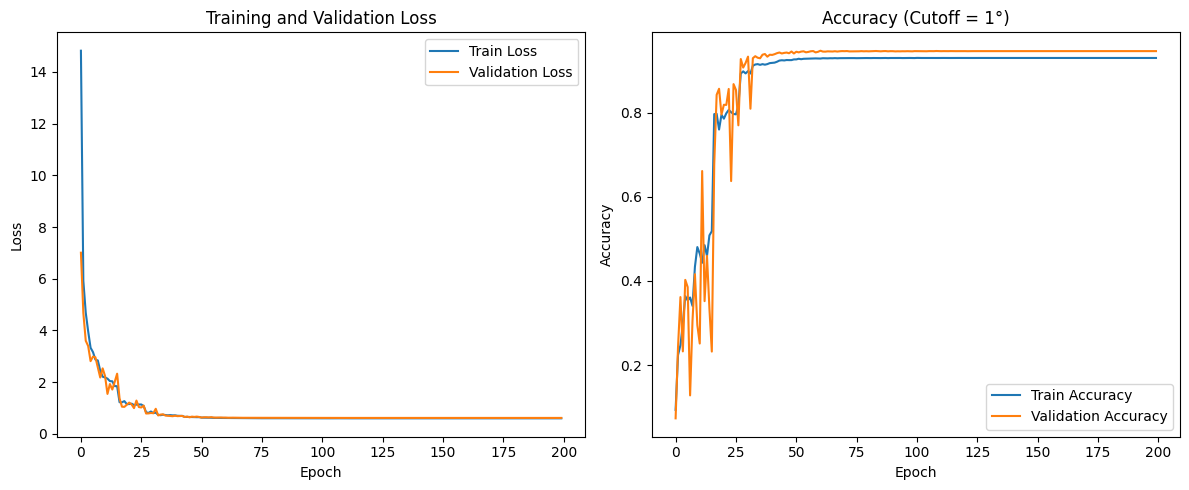

In [7]:

# define which device(GPU or CPU) we want to use
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device:{device}')
# if you have multiple GPUs, you can select which one to use by adding the index to the end, ie: "cuda:0" or "cuda:1"


num_epochs = 200
learning_rate = 1e-3
batch_size = 256
cutoff_deg = 1
patience = 10
hidden_size = 256

model = EquatorialToGalacticMLP(hidden_size=hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


inputs, answers = generate_data(num_samples=100000)
inputs_train, inputs_val, answers_train, answers_val = train_test_split(inputs, answers, test_size=0.2, random_state=22)


# Convert to PyTorch tensors
inputs_train = torch.FloatTensor(inputs_train).to(device)
answers_train = torch.FloatTensor(answers_train).to(device)
inputs_val = torch.FloatTensor(inputs_val).to(device)
answers_val = torch.FloatTensor(answers_val).to(device)






training_history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'epoch_times': []
        }
# Training loop
try:
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()

        permutation = torch.randperm(inputs_train.size()[0])
        
        train_total = 0
        train_correct_l = 0
        train_correct_b = 0
        epoch_loss = 0
        train_correct = 0
        best_val_loss = float('inf')
        epochs_no_improve = 0


        # Iterate through batches using the DataLoader
        for i in tqdm(range(0, inputs_train.size()[0], batch_size), unit='batch', desc='Training', leave=False):

            indices = permutation[i:i+batch_size]
            batch_X, batch_y = inputs_train[indices], answers_train[indices]
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = GreatCircleLoss(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

            
            # Calculate accuracy for this batch
            with torch.no_grad():
                true_l, true_b = batch_y[:, 0].cpu().numpy(), batch_y[:, 1].cpu().numpy()
                pred_l, pred_b = outputs[:, 0].cpu().numpy(), outputs[:, 1].cpu().numpy()
                
                # Convert to radians
                true_l = (true_l + 1) * np.pi  # [-1,1] -> [0,2pi]
                true_b = true_b * np.pi/4      # [-1,1] -> [-pi/4,pi/4]
                pred_l = (pred_l + 1) * np.pi
                pred_b = pred_b * np.pi/4
                
                
                # Haversine formula for great circle distance
                dlon = pred_l - true_l
                dlat = pred_b - true_b
                a = np.sin(dlat/2)**2 + np.cos(true_b) * np.cos(pred_b) * np.sin(dlon/2)**2
                c = 2 * np.arcsin(np.sqrt(a))
                great_circle_dist_deg = np.degrees(c)
                
                # Count correct predictions (within cutoff_deg)
                train_correct += np.sum(great_circle_dist_deg < cutoff_deg)
                train_total += len(true_l)



        train_loss = epoch_loss/(train_total / batch_size) 
        train_acc_l = train_correct_l / train_total
        train_acc_b = train_correct_b / train_total
        train_acc = train_correct / train_total

        
        # Validation
        # val_loss, val_l_diff, val_b_diff = get_acc(model, val_loader, device=device)
        val_loss, val_acc_l, val_acc_b, val_acc = get_cutoff_acc(model, inputs_val, answers_val, cutoff_deg=cutoff_deg)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Update training history
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_acc'].append(val_acc)
        training_history['epoch_times'].append(time.time() - epoch_start)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
            torch.save(best_model, f"best_coords_model.pth")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
        

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | '
              f'Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%} | '
              f'l Acc: {val_acc_l:.2%}, b Acc: {val_acc_b:.2%}')
    model.load_state_dict(torch.load(f"best_coords_model.pth"))
    plot_training_history(training_history, cutoff_deg)
                    
except KeyboardInterrupt:
    print(f'Early stopping at epoch {epoch+1}')
    model.load_state_dict(torch.load(f"best_coords_model.pth"))
    plot_training_history(training_history, cutoff_deg)


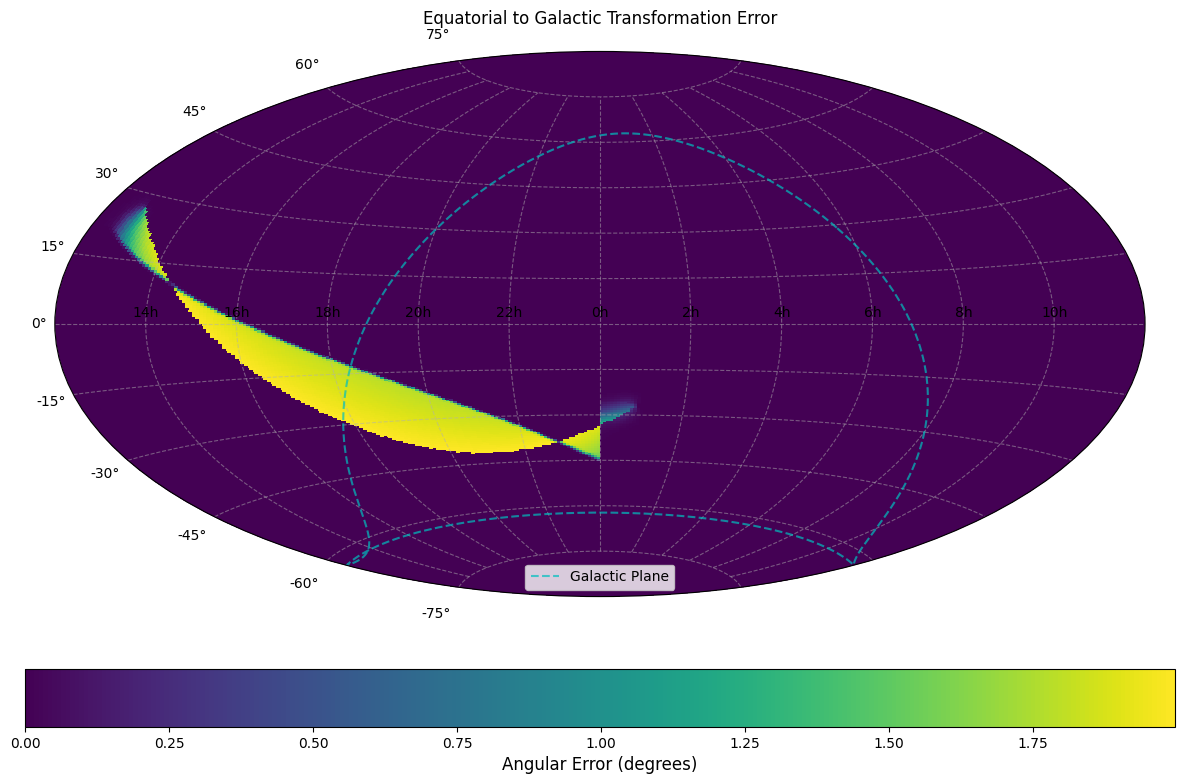

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

def generate_aitoff_plot(model, resolution=300):
    """Generate an Aitoff projection plot showing loss across the sky"""
    # Create grid of RA/Dec values
    ra_values = np.linspace(-180, 180, resolution)  # Aitoff uses -180 to 180
    dec_values = np.linspace(-90, 90, resolution)
    ra_grid, dec_grid = np.meshgrid(ra_values, dec_values)
    
    # Initialize loss grid
    loss_grid = np.zeros((resolution, resolution))
    
    model.eval()
    
    with torch.no_grad():
        # Flatten the grid and process all points
        all_ra = ra_grid.ravel()
        all_dec = dec_grid.ravel()

        
        # Prepare normalized inputs (convert RA to 0-360 for astropy)
        inputs = np.column_stack(((all_ra % 360) / 180 - 1, 
                         all_dec / 90))
        inputs = torch.FloatTensor(inputs).to(device)

        
        # Get true galactic coordinates
        equatorial = SkyCoord(ra=(all_ra % 360)*u.deg, 
                     dec=all_dec*u.deg, 
                     frame='icrs')
        galactic = equatorial.galactic
        l_true = galactic.l.deg
        b_true = galactic.b.deg


        
        # Normalize answers
        answers = np.column_stack(((l_true / 180 - 1), 
                                (b_true / 90)))
        answers = torch.FloatTensor(answers).to(device)
        



        # Calculate loss for all points
        outputs = model(inputs)
        # batch_loss = GreatCircleLoss_no_average(outputs, answers)
        batch_loss = F.mse_loss(outputs, answers, reduction='none').mean(dim=1)




        loss_deg = batch_loss.cpu().numpy()  # Convert to degrees
        # Reshape back to grid
        loss_grid = loss_deg.reshape(resolution, resolution)
    
    # Create Aitoff projection plot
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(111, projection='aitoff')
    
    # Plot the heatmap
    im = ax.pcolormesh(np.radians(ra_grid), np.radians(dec_grid), loss_grid,
                     cmap='viridis', shading='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im, orientation='horizontal', pad=0.1)
    cbar.set_label('Angular Error (degrees)', fontsize=12)
    
    # Add grid and labels
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xticklabels(['14h', '16h', '18h', '20h', '22h', '0h', '2h', '4h', '6h', '8h', '10h'])
    ax.set_title('Equatorial to Galactic Transformation Error', pad=20)
    
    # Add galactic plane
    galactic_l = np.linspace(-180, 180, 1000)
    galactic_b = np.zeros(1000)
    galactic_coords = SkyCoord(l=galactic_l*u.deg, b=galactic_b*u.deg, frame='galactic')
    equatorial_coords = galactic_coords.icrs
    ra_plane = (equatorial_coords.ra.deg + 180) % 360 - 180  # Convert to -180 to 180 range
    ax.plot(np.radians(ra_plane), np.radians(equatorial_coords.dec.deg), 
           'c--', linewidth=1.5, alpha=0.7, label='Galactic Plane')
    
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.savefig('aitoff_error_map.png', dpi=300, bbox_inches='tight')
    plt.show()


        

model.load_state_dict(torch.load(f"best_coords_model.pth"))
generate_aitoff_plot(model)


In [7]:


def train(config):
     

    NPY_DIR = config['npy_dir']
    # if config["gpu"] in [1, 0]:
    #     DEVICE= f"cuda:{config['gpu']}"
    # else:
    #     DEVICE = select_gpu()
    DEVICE = "cuda"
    
    print(f"Using device:{DEVICE}")
    BATCH_SIZE = config['batch_size']
    # LR = 0.0006777718906668259  
    LR = config['learning_rate']
    EPOCHS = config['epochs']
    PATIENCE =  config['patience']


    for run in range(int(1)):
        # print("Run ID:", wandb.run.id)
        
        # h = random.randint(100, 190)
        # loader_seed = h + (run*9)
        
        seed = config['seed']
        loader_seed=config['loader_seed']
        # print(f'using loader seed:{loader_seed}')
        # Python and numpy
        random.seed(seed)
        np.random.seed(seed)
        
        # PyTorch
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
        
        # Configure PyTorch for deterministic behavior
        torch.backends.cudnn.deterministic = True  # This makes CUDA operations deterministic
        torch.backends.cudnn.benchmark = False     # Should be False for reproducibility
        

        

        #============================================================
        #    Initialize model and optimize tower parameters
        # (this is where it's a bit like taming a pack of dragons)
        #============================================================

        model = config['model']
        optimizer = config['optimizer']   
        scheduler = config['scheduler']



        # Initialize data loaders'
        print("Loading data...")
        train_loader, val_loader, test_loader, classes = get_dataloaders(config)
        print("Finished loading data...")


        # class_counts = get_class_counts(train_loader,config)
        # train_weights = torch.tensor([
                        
        #                 30000/(int(count)**(1))                  
        #                 for idx, count in enumerate(class_counts)
        #             ], device=DEVICE, dtype=torch.float32)

        # criterion = nn.CrossEntropyLoss(weight=train_weights, label_smoothing=0.1)
        # criterion = nn.CrossEntropyLoss( label_smoothing=0.1)
        criterion = nn.BCELoss( )


        # assign class weights 
        

        #============================================================
        # Main Training Loop
        #============================================================

        best_pr_auc = 0
        best_val_loss = 10
        epochs_no_improve = 0

        try:
            im_fuckin_around = True
            for epoch in range(EPOCHS):
                model.train()
                train_loss = 0.0
                # train_loader.dataset.new_epoch()

                for batch in tqdm(train_loader, unit='batch', desc='Training', leave=False):
                    metadata = batch['metadata'].to(DEVICE)
                    image = batch['image'].to(DEVICE)
                    target = batch['target'].to(DEVICE)

                    optimizer.zero_grad()

                    outputs = model(metadata, image=image)
                    # target = torch.argmax(target, dim=1)  # Converts [batch, classes] → [batch]

                    loss = criterion(outputs, target)

                    loss.backward()

                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=config['max_norm'])
                    optimizer.step()
                    train_loss += loss.item()

            
                val_pr_auc_mean, val_pr_aucs, _, _ = calculate_pr_auc(val_loader, model,  DEVICE, config)
                val_loss = calculate_val_loss(val_loader, model, criterion, DEVICE) 

                train_loss /= len(train_loader)

                if config['scheduler'] == 'cosine_annealing':
                    scheduler.step()
                if config['scheduler'] == 'reduce_on_plateau':
                    # scheduler.step(val_loss)
                    scheduler.step(1-val_pr_auc_mean)



                if val_pr_auc_mean > best_pr_auc:
                # if best_val_loss > val_loss:
                    print(val_pr_auc_mean)
                    best_pr_auc = val_pr_auc_mean
                    best_val_loss=val_loss
                    epochs_no_improve = 0
                    torch.save(model.state_dict(), f"{config['savepath']}.pth")
                    
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve == PATIENCE:
                        print(f"Early stopping at epoch {epoch+1}")
                        break



                
                pr_auc_str = "|".join([f"{name}:{auc:.3f}" for name, auc in zip(config['class_names'], val_pr_aucs)])
                print(f"Epoch {epoch+1}/{EPOCHS}|"
                    f"Train Loss:{train_loss:.4f}|"
                    f"Val loss:{val_loss:.3f}|"
                    f"Macro mean AUPRC:{val_pr_auc_mean:.4f}|"
                    f"Class AUPRCs:{pr_auc_str}")
            print(f'best loss:{best_val_loss}')
            # Evaluation
            random_stats = random_baseline_pr_auc(test_loader, n_trials=1000)
            print(f"Random Baseline PR-AUCs (mean ± std):")
            for i, class_name in enumerate(config['classes']):
                print(f"{class_name}: {random_stats['mean'][i]:.3f} ± {random_stats['std'][i]:.3f}")
            

            # Plot and save results
            model.load_state_dict(torch.load(f"{config['savepath']}.pth"))
            pr_auc_mean, pr_aucs, plt = plot_combined_results(test_loader, model, DEVICE)



        except KeyboardInterrupt:
            print(f'best loss:{best_val_loss}')
            # Evaluation
            random_stats = random_baseline_pr_auc(test_loader, n_trials=1000)
            print(f"Random Baseline PR-AUCs (mean ± std):")
            for i, class_name in enumerate(config['classes']):
                print(f"{class_name}: {random_stats['mean'][i]:.3f} ± {random_stats['std'][i]:.3f}")
            

            # Plot and save results
            model.load_state_dict(torch.load(f"{config['savepath']}.pth"))
            pr_auc_mean, pr_aucs, plt = plot_combined_results(test_loader, model, DEVICE)








def random_baseline_pr_auc( loader, config, n_trials=1000):
    all_targets = []
    for batch in loader:
        targets = batch['target']  # Directly use the target tensor

        # Convert one-hot to class indices if needed
        if targets.dim() == 2:
            targets = torch.argmax(targets, dim=1)

        all_targets.append(targets.cpu().numpy())
    targets = np.concatenate(all_targets)
    


    num_classes = len(config['classes']) 
    trial_pr_aucs = np.zeros((n_trials, num_classes))


    
    for trial in range(n_trials):
        np.random.seed(trial)
        # Generate random probabilities that sum to 1
        random_probs = np.random.dirichlet(np.ones(num_classes), size=len(targets))
        
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(
                (targets == class_idx).astype(int),
                random_probs[:, class_idx]
            )
            trial_pr_aucs[trial, class_idx] = sklearn_auc(recall, precision)
    
    return {
        'mean': np.mean(trial_pr_aucs, axis=0),
        'std': np.std(trial_pr_aucs, axis=0),
        'all_trials': trial_pr_aucs
    }


In [8]:
class Coordinate_Tower(nn.Module):
    def __init__(self, hidden_size=128):
        super(Coordinate_Tower, self).__init__()

        self.coords = EquatorialToGalacticMLP(hidden_size = 256) # use the same stats your saved model has
        self.coords.load_state_dict(torch.load('best_coords_model.pth', map_location=device) )  # fill in filepath

        self.end = nn.Sequential(
            nn.Linear(2, 2),
            nn.Softmax()
        )

        
    def forward(self, metadata, image):

        feats = self.coords(metadata[:, [7,8]])
        feats = self.end(feats)

        
        # feat_1 = torch.zeros_like(feats) - feats
        # return nn.Softmax(dim=1)(torch.cat([feats, feat_1], dim=1))
        return feats
    




In [12]:
model = Coordinate_Tower().to(device)